<a href="https://colab.research.google.com/github/JuniorProject21/DrugDiscovery/blob/main/Drug_discovery_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the dataset

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

# Install the official RDKit package
!pip -q install rdkit

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.feature_selection import VarianceThreshold

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 20.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
!pip -q install lazypredict

from lazypredict.Supervised import LazyClassifier
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.1/811.1 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.5 MB/s eta 0:00:00


# Data Acquisition and Cleaning

In [ ]:
# Load dataset
df_raw = pd.read_csv("/content/drive/MyDrive/dataset.csv", sep=',', low_memory=False)

# Select relevant columns
cols = ['BindingDB Reactant_set_id', 'Ligand SMILES', 'IC50 (nM)',
        'Target Source Organism According to Curator or DataSource']
df = df_raw[cols].copy()

# Filter for Human targets and drop rows with missing values
df = df[df['Target Source Organism According to Curator or DataSource'].isin(['Homo sapiens', 'Human'])]
df = df.dropna(subset=['IC50 (nM)', 'Ligand SMILES'])

In [ ]:
df

In [ ]:
# 1. Clean IC50 and Organism
def clean_data(df):
    # Parse IC50 strings (removing <, > and converting to float)
    df['IC50_nM_clean'] = df['IC50 (nM)'].astype(str).str.replace(r'[<>]', '', regex=True)
    df['IC50_nM_clean'] = pd.to_numeric(df['IC50_nM_clean'], errors='coerce')

    # Drop NaNs and filter for Human targets
    df = df.dropna(subset=['IC50_nM_clean', 'Ligand SMILES'])
    df = df[df['Target Source Organism According to Curator or DataSource'].isin(['Homo sapiens', 'Human'])].copy()

    # 2. Calculate pIC50 (Standard for ML)
    # Ensure no zero values before log transformation
    df = df[df['IC50_nM_clean'] > 0].copy()
    df['pIC50'] = -np.log10(df['IC50_nM_clean'] * 1e-9)

    # 3. Classify Activity (Active = 1, Inactive = 0)
    df['activity'] = np.where(df['IC50_nM_clean'] <= 1000.0, 1, 0)

    return df

df = clean_data(df)
print(f"Dataset cleaned. Active count: {df.activity.sum()} | Total: {len(df)}")

Dataset cleaned. Active count: 3818 | Total: 5072


In [ ]:
# Save the cleaned dataframe to Google Drive
file_path = "/content/drive/MyDrive/dataset_clean.csv"
df.to_csv(file_path, index=False)
print(f"Cleaned dataset saved successfully to: {file_path}")

Cleaned dataset saved successfully to: /content/drive/MyDrive/dataset_clean.csv


# Lipinski descriptors (not mandatory)

In [ ]:
## maybe added later.

# Fingerprints



In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray

# -------- Optimal fingerprint settings (from your experiment) --------
RADIUS = 3
NBITS = 4096

gen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS, fpSize=NBITS)

def get_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = gen.GetFingerprint(mol)
    arr = np.zeros((NBITS,), dtype=np.int8)
    ConvertToNumpyArray(fp, arr)
    return arr

# df must already exist and contain these columns
# df["Ligand SMILES"], df["activity"] (and/or IC50/pIC50 columns depending on your notebook)

smiles_all = df["Ligand SMILES"].astype(str).tolist()
fps = [get_fp(s) for s in smiles_all]

valid_indices = [i for i, f in enumerate(fps) if f is not None]
print("Valid molecules:", len(valid_indices), " / ", len(df))

# X = fingerprints only (aligned with df_final)
X = np.stack([fps[i] for i in valid_indices]).astype(np.float32)
df_final = df.iloc[valid_indices].reset_index(drop=True)

# Labels aligned with X
y = df_final["activity"].astype(int).to_numpy()

print("X shape:", X.shape, " y shape:", y.shape)

[09:20:30] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[09:20:30] Explicit valence for atom # 5 N, 4, is greater than permitted


Valid molecules: 5070  /  5072
X shape: (5070, 4096)  y shape: (5070,)


In [ ]:
from sklearn.feature_selection import VarianceThreshold

# ---- Full fingerprint dataframe (4096 bits) ----
fp_cols_full = [f'fp_{i}' for i in range(NBITS)]
df_fps_full = pd.DataFrame(X.astype(np.int8), columns=fp_cols_full)
df_ready_full = pd.concat([df_final.reset_index(drop=True), df_fps_full], axis=1)

# ---- Remove zero-variance bits ----
selector = VarianceThreshold(threshold=0.0)
X_reduced = selector.fit_transform(X)  # this becomes your final Xf for modeling

mask = selector.get_support()
kept_cols = [fp_cols_full[i] for i, keep in enumerate(mask) if keep]

df_fps_reduced = pd.DataFrame(X_reduced.astype(np.int8), columns=kept_cols)
df_ready_reduced = pd.concat([df_final.reset_index(drop=True), df_fps_reduced], axis=1)

print(f"Features reduced from {NBITS} to {X_reduced.shape[1]} bits.")

# ---- Save to Drive ----
base = "/content/drive/MyDrive"
full_path = f"{base}/dataset_features_ECFP6_r3_4096_FULL.csv"
reduced_path = f"{base}/dataset_features_ECFP6_r3_4096_REDUCED.csv"
mask_path = f"{base}/fingerprint_keep_mask_ECFP6_r3_4096.npy"

df_ready_full.to_csv(full_path, index=False)
df_ready_reduced.to_csv(reduced_path, index=False)
np.save(mask_path, mask)

print("Saved full dataset:", full_path)
print("Saved reduced dataset:", reduced_path)
print("Saved keep-mask:", mask_path)

# Choose which X to use for modeling:
Xf = X_reduced  # recommended

Features reduced from 4096 to 4088 bits.
Saved full dataset: /content/drive/MyDrive/dataset_features_ECFP6_r3_4096_FULL.csv
Saved reduced dataset: /content/drive/MyDrive/dataset_features_ECFP6_r3_4096_REDUCED.csv
Saved keep-mask: /content/drive/MyDrive/fingerprint_keep_mask_ECFP6_r3_4096.npy


In [ ]:
print(X.shape)
print(np.unique(X))


(5070, 4096)
[0. 1.]


# Scaffold split
- A scaffold split is a method in molecular machine learning and cheminformatics that divides a chemical dataset based on the core structural framework (scaffold) of molecules. By ensuring that no molecule sharing a scaffold in the training set appears in the validation or test sets, this method simulates real-world drug discovery scenarios, testing model generalizability to new chemical series

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict

def murcko(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaf = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaf, isomericSmiles=False)

smiles_list = df_final["Ligand SMILES"].astype(str).tolist()
scaffolds = [murcko(s) for s in smiles_list]

scaf_to_idx = defaultdict(list)
for i, sc in enumerate(scaffolds):
    if sc is not None:
        scaf_to_idx[sc].append(i)

groups = sorted(scaf_to_idx.values(), key=len, reverse=True)

test_fraction = 0.2
n_total = len(df_final)
n_test_target = int(test_fraction * n_total)

test_idx = []
train_idx = []

for g in groups:
    # add whole scaffold group to test until target reached
    if len(test_idx) < n_test_target:
        test_idx.extend(g)
    else:
        train_idx.extend(g)

train_idx = np.array(train_idx, dtype=int)
test_idx = np.array(test_idx, dtype=int)

X_train, X_test = Xf[train_idx], Xf[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Test fraction actual:", len(test_idx)/n_total)

Train: (4056, 4088)  Test: (1014, 4088)
Test fraction actual: 0.2


#Training different ML models

In [ ]:
from lazypredict.Supervised import LazyClassifier

X_train_lp = X_train.astype(float)
X_test_lp  = X_test.astype(float)

clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train_lp, X_test_lp, y_train, y_test)

# Save leaderboards/results
models_path = "/content/drive/MyDrive/lazypredict_models_ECFP6_r3_4096.csv"
preds_path  = "/content/drive/MyDrive/lazypredict_predictions_ECFP6_r3_4096.csv"

models.to_csv(models_path, index=True)
predictions.to_csv(preds_path, index=False)

print("Saved model leaderboard:", models_path)
print("Saved predictions table:", preds_path)

models.head(10)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3076, number of negative: 980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7536
[LightGBM] [Info] Number of data points in the train set: 4056, number of used features: 2512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.758383 -> initscore=1.143833
[LightGBM] [Info] Start training from score 1.143833
Saved model leaderboard: /content/drive/MyDrive/lazypredict_models_ECFP6_r3_4096.csv
Saved predictions table: /content/drive/MyDrive/lazypredict_predictions_ECFP6_r3_4096.csv


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.79,0.83,0.83,0.80,0.95
BaggingClassifier,0.82,0.77,0.77,0.82,19.34
DecisionTreeClassifier,0.82,0.77,0.77,0.82,2.26
PassiveAggressiveClassifier,0.80,0.75,0.75,0.80,2.75
LGBMClassifier,0.84,0.74,0.74,0.83,2.65
KNeighborsClassifier,0.81,0.74,0.74,0.80,1.95
NearestCentroid,0.77,0.73,0.73,0.78,0.97
XGBClassifier,0.83,0.73,0.73,0.82,3.66
LinearSVC,0.77,0.73,0.73,0.77,29.21


In [ ]:
models

# Top 10 models

[LightGBM] [Info] Number of positive: 3076, number of negative: 980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5024
[LightGBM] [Info] Number of data points in the train set: 4056, number of used features: 2512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.758383 -> initscore=1.143833
[LightGBM] [Info] Start training from score 1.143833


,Model,ROC_AUC,PR_AUC,Accuracy,Balanced_Accuracy,F1
0,XGBClassifier,0.93,0.96,0.83,0.73,0.89
1,LGBMClassifier,0.92,0.97,0.84,0.74,0.90
2,KNeighborsClassifier,0.92,0.96,0.85,0.79,0.90
3,BaggingClassifier,0.89,0.94,0.82,0.77,0.88
4,BernoulliNB,0.86,0.94,0.79,0.83,0.84
5,DecisionTreeClassifier,0.79,0.88,0.82,0.77,0.87


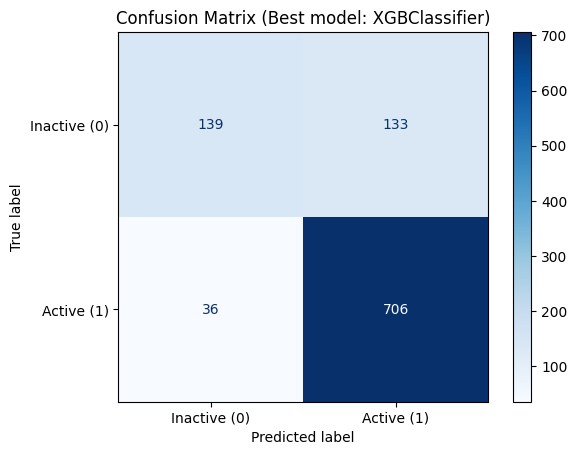

Best model by ROC_AUC: XGBClassifier


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Optional models
try:
    from lightgbm import LGBMClassifier
    has_lgbm = True
except Exception:
    has_lgbm = False

try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return model.predict(X)

models_to_eval = {
    "BernoulliNB": BernoulliNB(),
    "BaggingClassifier": BaggingClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
}

if has_lgbm:
    models_to_eval["LGBMClassifier"] = LGBMClassifier(random_state=42)

if has_xgb:
    models_to_eval["XGBClassifier"] = XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )

rows = []
fitted_models = {}

for name, model in models_to_eval.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model

    scores = get_scores(model, X_test)
    y_pred = model.predict(X_test)

    rows.append({
        "Model": name,
        "ROC_AUC": roc_auc_score(y_test, scores),
        "PR_AUC": average_precision_score(y_test, scores),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Balanced_Accuracy": balanced_accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
    })

auc_df = pd.DataFrame(rows).sort_values(["ROC_AUC", "PR_AUC"], ascending=False).reset_index(drop=True)
display(auc_df)

# Confusion matrix for best model (by ROC_AUC)
best_name = auc_df.iloc[0]["Model"]
best_model = fitted_models[best_name]

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Inactive (0)", "Active (1)"])
disp.plot(ax=ax, values_format="d", cmap="Blues")   # <-- blue theme
ax.grid(False)                                      # optional: cleaner
plt.title(f"Confusion Matrix (Best model: {best_name})")
plt.show()

print("Best model by ROC_AUC:", best_name)

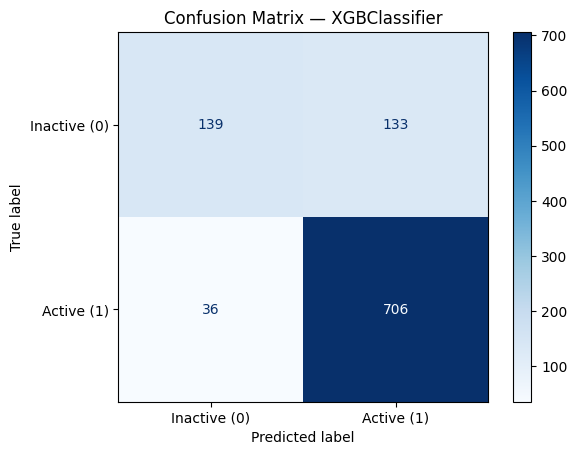

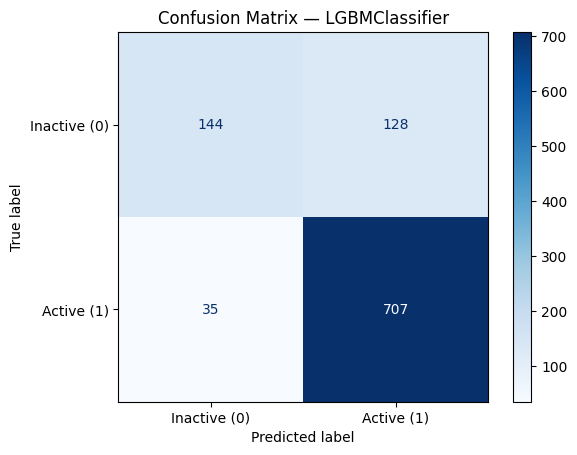

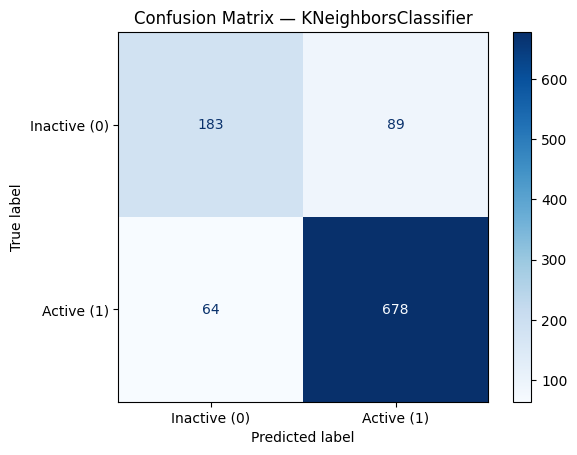

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

top_n = 3
top_models = auc_df["Model"].head(top_n).tolist()

for name in top_models:
    model = fitted_models[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(cm, display_labels=["Inactive (0)", "Active (1)"])
    disp.plot(ax=ax, values_format="d", cmap="Blues")  # <- blue theme
    plt.title(f"Confusion Matrix — {name}")

    plt.show()

# EXPERIMENT

In [ ]:
# ============================
# EXPERIMENT: Representation / Feature Engineering
# (Safe: does NOT modify your existing train_idx/test_idx)
# ============================

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors
from rdkit.DataStructs import ConvertToNumpyArray

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ---------- 0) Make sure we have a validation set ----------
# If you already have val_idx defined, it will use it.
# If not, it will split it from train_idx (keeping test_idx untouched).
if "val_idx" not in globals():
    train_idx_arr = np.array(train_idx, dtype=int)
    rng = np.random.RandomState(42)
    perm = rng.permutation(train_idx_arr)

    val_size = max(1, int(0.125 * len(train_idx_arr)))  # ~12.5% of train
    val_idx = perm[:val_size]
    train_idx2 = perm[val_size:]
else:
    train_idx2 = np.array(train_idx, dtype=int)
    val_idx = np.array(val_idx, dtype=int)

print(f"[Representation Exp] train_idx2={len(train_idx2)}  val_idx={len(val_idx)}  test_idx={len(test_idx)}")

# ---------- 1) Helpers ----------
DESC_FUNCS = [
    ("MolWt", Descriptors.MolWt),
    ("MolLogP", Descriptors.MolLogP),
    ("TPSA", Descriptors.TPSA),
    ("HBD", Descriptors.NumHDonors),
    ("HBA", Descriptors.NumHAcceptors),
    ("RotB", Descriptors.NumRotatableBonds),
    ("RingCount", Descriptors.RingCount),
]

def featurize(smiles_list, radius=2, nbits=2048, add_desc=False):
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nbits)

    fps = []
    descs = []
    bad = 0

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            bad += 1
            fp_arr = np.zeros((nbits,), dtype=np.int8)
            fps.append(fp_arr)
            if add_desc:
                descs.append([0.0] * len(DESC_FUNCS))
            continue

        fp = gen.GetFingerprint(mol)
        fp_arr = np.zeros((nbits,), dtype=np.int8)
        ConvertToNumpyArray(fp, fp_arr)
        fps.append(fp_arr)

        if add_desc:
            descs.append([fn(mol) for _, fn in DESC_FUNCS])

    X_fp = np.vstack(fps).astype(np.float32)

    if not add_desc:
        return X_fp, bad

    # Descriptors (scale only descriptors)
    X_desc = np.array(descs, dtype=np.float32)

    scaler = StandardScaler()
    X_desc_scaled = scaler.fit_transform(X_desc)

    X_all = np.hstack([X_fp, X_desc_scaled]).astype(np.float32)
    return X_all, bad

def eval_config(X_feat, y, train_idx_used, val_idx_used):
    model = LogisticRegression(max_iter=2000, n_jobs=-1)

    X_tr, y_tr = X_feat[train_idx_used], y[train_idx_used]
    X_va, y_va = X_feat[val_idx_used], y[val_idx_used]

    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]
    pred = (proba >= 0.5).astype(int)

    roc = roc_auc_score(y_va, proba)
    pr  = average_precision_score(y_va, proba)
    acc = accuracy_score(y_va, pred)
    return roc, pr, acc

# ---------- 2) Run experiment grid ----------
smiles_list = df_final["Ligand SMILES"].astype(str).tolist()
y_arr = df_final["activity"].astype(int).to_numpy()

configs = [(r, b, d) for r in [2, 3] for b in [1024, 2048, 4096] for d in [False, True]]

rows = []
for radius, nbits, add_desc in configs:
    X_feat, bad = featurize(smiles_list, radius=radius, nbits=nbits, add_desc=add_desc)

    roc, pr, acc = eval_config(X_feat, y_arr, train_idx2, val_idx)

    rows.append({
        "radius": radius,
        "nbits": nbits,
        "descriptors": add_desc,
        "val_ROC_AUC": roc,
        "val_PR_AUC": pr,
        "val_Accuracy": acc,
        "bad_smiles": bad,
        "feature_dim": X_feat.shape[1],
    })

results_df = pd.DataFrame(rows).sort_values(["val_ROC_AUC", "val_PR_AUC"], ascending=False).reset_index(drop=True)
results_df

[Representation Exp] train_idx2=3549  val_idx=507  test_idx=1014


,radius,nbits,descriptors,val_ROC_AUC,val_PR_AUC,val_Accuracy,bad_smiles,feature_dim
0,3,4096,True,0.95,0.98,0.90,0,4103
1,3,4096,False,0.95,0.98,0.90,0,4096
2,3,2048,True,0.94,0.98,0.90,0,2055
3,3,2048,False,0.94,0.98,0.90,0,2048
4,3,1024,True,0.94,0.98,0.88,0,1031
5,3,1024,False,0.94,0.98,0.88,0,1024
6,2,4096,False,0.94,0.98,0.88,0,4096
7,2,4096,True,0.94,0.98,0.88,0,4103
8,2,2048,True,0.93,0.98,0.89,0,2055
9,2,2048,False,0.93,0.98,0.89,0,2048


In [ ]:
import numpy as np
import random
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

# ---------- Settings ----------
RADIUS = 3
NBITS = 4096
SEED = 42
PAIRS = 2000  # only used for the "random-pairs" statistic

random.seed(SEED)
np.random.seed(SEED)

smiles = df_final["Ligand SMILES"].astype(str).tolist()
y_arr = df_final["activity"].astype(int).to_numpy()

# Initialize the Morgan fingerprint generator once
fp_gen_morgan = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS, fpSize=NBITS)

# ---------- Fingerprints ----------
def morgan_fp(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    # Use the pre-initialized generator
    return fp_gen_morgan.GetFingerprint(mol)

fps = []
bad = 0
for smi in smiles:
    fp = morgan_fp(smi)
    if fp is None:
        bad += 1
    fps.append(fp)

print("Bad SMILES:", bad)

valid_idx = np.array([i for i, fp in enumerate(fps) if fp is not None], dtype=int)

# ---------- Helper 1: random cross-pair similarity (weak signal, but ok to report) ----------
def cross_pair_summary(train_indices, test_indices, pairs=PAIRS):
    train_indices = [i for i in train_indices if fps[i] is not None]
    test_indices  = [i for i in test_indices  if fps[i] is not None]

    sims = []
    for _ in range(pairs):
        i = random.choice(train_indices)
        j = random.choice(test_indices)
        sims.append(DataStructs.TanimotoSimilarity(fps[i], fps[j]))

    sims = np.array(sims, dtype=float)
    return {
        "pairs_used": len(sims),
        "mean": float(sims.mean()),
        "median": float(np.median(sims)),
        "p90": float(np.percentile(sims, 90)),
        "max": float(sims.max()),
    }

# ---------- Helper 2: nearest-neighbor similarity (BEST leakage test) ----------
def nn_summary(train_indices, test_indices):
    train_indices = [i for i in train_indices if fps[i] is not None]
    test_indices  = [i for i in test_indices  if fps[i] is not None]

    train_fps = [fps[i] for i in train_indices]
    nn_sims = []

    for j in test_indices:
        sims = DataStructs.BulkTanimotoSimilarity(fps[j], train_fps)
        nn_sims.append(max(sims))

    nn_sims = np.array(nn_sims, dtype=float)
    return {
        "test_size": len(test_indices),
        "mean_nn": float(nn_sims.mean()),
        "median_nn": float(np.median(nn_sims)),
        "p90_nn": float(np.percentile(nn_sims, 90)),
        "max_nn": float(nn_sims.max()),
        "pct_nn_ge_0.5": float((nn_sims >= 0.5).mean()),   # optional but very convincing
        "pct_nn_ge_0.7": float((nn_sims >= 0.7).mean()),
    }

# ---------- A) Scaffold split (use your existing indices) ----------
train_scaf = [i for i in train_idx if i in set(valid_idx)]
test_scaf  = [i for i in test_idx  if i in set(valid_idx)]

# ---------- B) Random split with SAME test size ----------
test_ratio = len(test_scaf) / len(valid_idx)
rand_train, rand_test = train_test_split(
    valid_idx, test_size=test_ratio, random_state=SEED, stratify=y_arr[valid_idx]
)

# ---------- Compute summaries ----------
scaf_pairs = cross_pair_summary(train_scaf, test_scaf, pairs=PAIRS)
rand_pairs = cross_pair_summary(rand_train, rand_test, pairs=PAIRS)

scaf_nn = nn_summary(train_scaf, test_scaf)
rand_nn = nn_summary(rand_train, rand_test)

pairs_df = pd.DataFrame([
    {"Split": "Scaffold", **scaf_pairs},
    {"Split": "Random",   **rand_pairs},
])

nn_df = pd.DataFrame([
    {"Split": "Scaffold", **scaf_nn},
    {"Split": "Random",   **rand_nn},
])

print("\nRandom cross-pair similarity (weak leakage signal):")
display(pairs_df)

print("\nNearest-neighbor similarity (best leakage test):")
display(nn_df)

Bad SMILES: 0

Random cross-pair similarity (weak leakage signal):


,Split,pairs_used,mean,median,p90,max
0,Scaffold,2000,0.12,0.10,0.17,0.73
1,Random,2000,0.12,0.10,0.17,1.00



Nearest-neighbor similarity (best leakage test):


,Split,test_size,mean_nn,median_nn,p90_nn,max_nn,pct_nn_ge_0.5,pct_nn_ge_0.7
0,Scaffold,1014,0.62,0.64,0.85,0.90,0.78,0.31
1,Random,1014,0.79,0.78,1.00,1.00,0.95,0.72


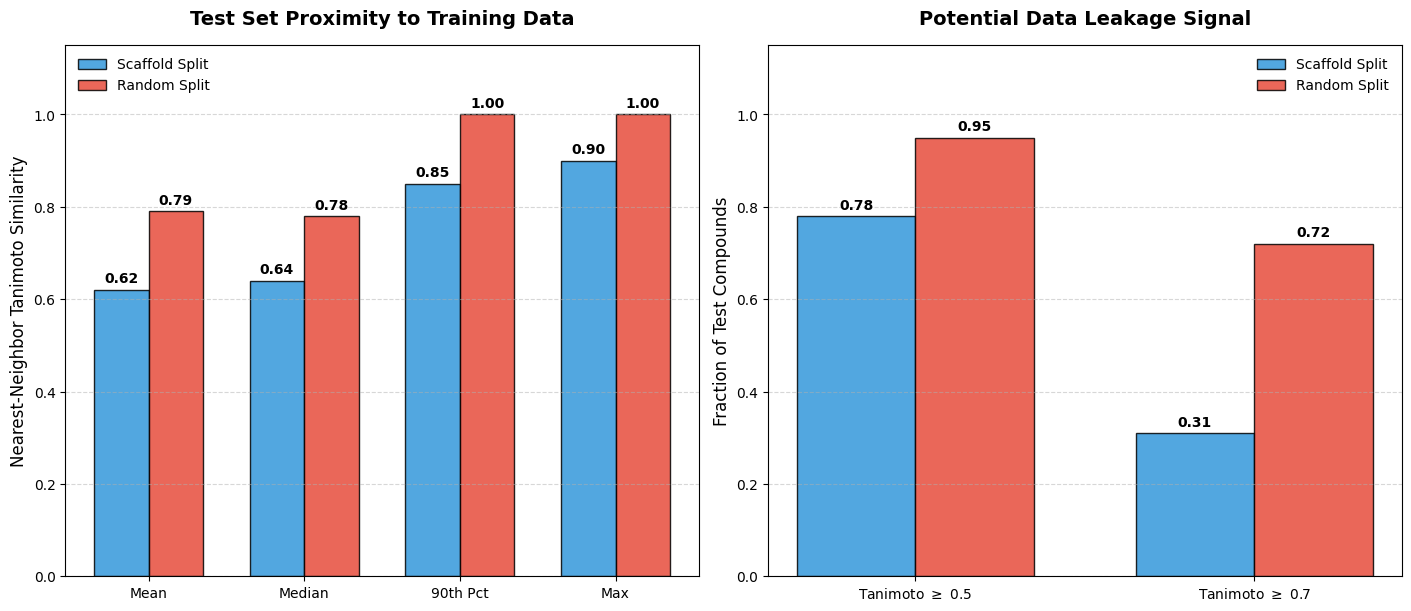

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data Preparation ---
scaffold = {
    "mean_nn": 0.62, "median_nn": 0.64, "p90_nn": 0.85, "max_nn": 0.90,
    "pct_nn_ge_0.5": 0.78, "pct_nn_ge_0.7": 0.31
}
random_split = {
    "mean_nn": 0.79, "median_nn": 0.78, "p90_nn": 1.00, "max_nn": 1.00,
    "pct_nn_ge_0.5": 0.95, "pct_nn_ge_0.7": 0.72
}

# Values for Plot 1 (Stats)
labels_stats = ["Mean", "Median", "90th Pct", "Max"]
vals_scaf = [scaffold["mean_nn"], scaffold["median_nn"], scaffold["p90_nn"], scaffold["max_nn"]]
vals_rand = [random_split["mean_nn"], random_split["median_nn"], random_split["p90_nn"], random_split["max_nn"]]

# Values for Plot 2 (Thresholds/Leakage)
labels_thr = ["Tanimoto $\geq$ 0.5", "Tanimoto $\geq$ 0.7"]
vals_scaf2 = [scaffold["pct_nn_ge_0.5"], scaffold["pct_nn_ge_0.7"]]
vals_rand2 = [random_split["pct_nn_ge_0.5"], random_split["pct_nn_ge_0.7"]]

# --- Plotting Configuration ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
color_scaf = '#3498db'  # Professional Blue
color_rand = '#e74c3c'  # Professional Red
width = 0.35
x = np.arange(len(labels_stats))
x2 = np.arange(len(labels_thr))

# Helper function for data labels
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Plot 1: NN Similarity Stats ---
rects1 = ax1.bar(x - width/2, vals_scaf, width, label='Scaffold Split', color=color_scaf, edgecolor='black', alpha=0.85)
rects2 = ax1.bar(x + width/2, vals_rand, width, label='Random Split', color=color_rand, edgecolor='black', alpha=0.85)

ax1.set_ylabel('Nearest-Neighbor Tanimoto Similarity', fontsize=12)
ax1.set_title('Test Set Proximity to Training Data', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(labels_stats)
ax1.set_ylim(0, 1.15) # Leave space for labels
ax1.legend(frameon=False)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# --- Plot 2: Leakage Thresholds ---
rects3 = ax2.bar(x2 - width/2, vals_scaf2, width, label='Scaffold Split', color=color_scaf, edgecolor='black', alpha=0.85)
rects4 = ax2.bar(x2 + width/2, vals_rand2, width, label='Random Split', color=color_rand, edgecolor='black', alpha=0.85)

ax2.set_ylabel('Fraction of Test Compounds', fontsize=12)
ax2.set_title('Potential Data Leakage Signal', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x2)
ax2.set_xticklabels(labels_thr)
ax2.set_ylim(0, 1.15)
ax2.legend(frameon=False)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
autolabel(rects3, ax2)
autolabel(rects4, ax2)

plt.savefig('improved_visualization.png', dpi=300)